###Connecting to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


##Imports


In [ ]:
# import locale
# locale.getpreferredencoding = lambda x=False: "UTF-8"
# !pip install alibi

In [ ]:
import torch
import torch.nn as nn
from torch.nn import BCELoss, CrossEntropyLoss
from torch.optim import Adam, RMSprop
import torch.nn.functional as f
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch.utils.data import Dataset, DataLoader

import os
import tqdm
import numpy as np
import pandas as pd
import math
import gc


import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import csv
import json
import collections
import logging
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction import _stop_words
from spacy.lang.en.stop_words import STOP_WORDS as spacy_stopwords
# from gensim.models import KeyedVectors
from tqdm import tqdm
use_cuda = True if torch.cuda.is_available() else False
# from alibi.explainers import Counterfactual
from torch.nn.modules import Embedding

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##Dataset Class

In [ ]:
class TextDataset(Dataset):

    def __init__(self, text_file_path, labels_file_path, w2i_file_path, bow_file_path, i2w_file_path, mode='train'):
        super(TextDataset, self).__init__()
        # load train data

        self.text_file_path = text_file_path
        self.labels_file_path = labels_file_path
        self.w2i_file_path = w2i_file_path
        self.bow_file_path = bow_file_path
        self.i2w_file_path = i2w_file_path
        self.pad_token = 0
        self.sos_token = 1
        self.unk_token = 2
        self.eos_token = 9189
        self.max_seq_len = 15
        self.bow_hidden_dim = 8229

        with open(self.text_file_path) as f:
            self.train_data = f.readlines()
        # load train labels
        with open(self.labels_file_path) as f:
            self.train_labels = f.readlines()
        # load word2index
        with open(self.w2i_file_path) as f:
            self.word2index = json.load(f)
        #load index2word
        with open(self.i2w_file_path) as f:
            self.index2word = json.load(f)
        # load bow vocab
        with open(self.bow_file_path) as f:
            self.bow_filtered_vocab_indices = json.load(f)
        self.label2index = {'neg': [0, 1], 'pos': [1, 0]}
        self.word2index['<eos>'] = 9189
        self.index2word['9189'] = '<eos>'


    def _padding(self, token_ids):
        if len(token_ids) > self.max_seq_len:
            return token_ids[:self.max_seq_len]
        token_ids = token_ids + (self.max_seq_len-len(token_ids))*[self.pad_token]

        return token_ids

    def _sentence_tokenid(self, sentence):
        sentence = sentence + "<eos>"
        token_ids = [self.word2index.get(word, self.unk_token) for word in sentence.split()]
        padded_token_ids = self._padding(token_ids)
        return padded_token_ids, len(token_ids)

    def _get_bow_representations(self, text_sequence):
        sequence_bow_representation = np.zeros(
            shape=self.bow_hidden_dim, dtype=np.float32)
        # Iterate over each word in the sequence
        for index in text_sequence:
            if index in self.bow_filtered_vocab_indices:
                bow_index = self.bow_filtered_vocab_indices[index]
                sequence_bow_representation[bow_index] += 1
        sequence_bow_representation /= np.max(
            [np.sum(sequence_bow_representation), 1])

        return np.asarray(sequence_bow_representation) #8229 one hot

    def __len__(self):

        return len(self.train_labels)

    def __getitem__(self, index):
        sentence = self.train_data[index]
        label = self.train_labels[index].strip()
        label_final = self.label2index[label]
        token_ids, seq_len = self._sentence_tokenid(sentence)
        bow_rep = self._get_bow_representations(sentence)
        sos_token = self.word2index.get("<sos>") #1

        data = dict()
        data['bow'] = torch.FloatTensor(bow_rep)
        data['label'] = torch.LongTensor(label_final) #[1,0] or [0,1]
        data['input_sequence'] = torch.LongTensor(token_ids) #[tokens] size 15
        data['sos_start'] = torch.LongTensor([sos_token]) #(batchsize, 1)

        return data, sentence, label

##Model Architecture - Variational AutoEncoder

####RNN -GRU

In [ ]:

class VAE_with_RNN(nn.Module):
  def __init__(self, vocab_size, weights_path, rnn_hidden_dim, rnn_hidden_dim_combined, style_hidden_dim, 
               content_hidden_dim, max_seq_length, embedding_size, bow_size, 
               concat_embedding_dim, num_styles,
               dropout, lambdas, kl_params, batch_size, epochs, label_smooth):
    super(VAE_with_RNN, self).__init__()
    self.vocab_size = vocab_size
    self.rnn_hidden_dim = rnn_hidden_dim #256
    self.rnn_hidden_dim_combined = rnn_hidden_dim_combined #512
    self.content_hidden_dim = content_hidden_dim #128
    self.style_hidden_dim = style_hidden_dim #8
    self.epochs = epochs #20
    self.label_smooth = label_smooth #0.1
    self.max_seq_length = max_seq_length #15
    self.batch_size = batch_size #128
    self.bow_size = bow_size #8229
    self.weights = torch.from_numpy(np.load(weights_path)) 
    #embedding weights

    self.dropout_layer = nn.Dropout(p=dropout) #dropout
    # self.transformer_encoder = nn.TransformerEncoderLayer(embedding_size, nhead=1, dim_feedforward=1024, batch_first=True)
    # self.transformer_decoder = nn.TransformerDecoderLayer(embedding_size + style_hidden_dim + content_hidden_dim, nhead=1, dim_feedforward=1024, batch_first=True)
    self.embedding = nn.Embedding(self.vocab_size, embedding_size).from_pretrained(self.weights) #9189
    self.gru_encoder = nn.GRU(embedding_size, rnn_hidden_dim, bidirectional=True, batch_first=True)
    self.style_mu = nn.Linear(rnn_hidden_dim_combined, style_hidden_dim)
    self.style_sigma = nn.Linear(rnn_hidden_dim_combined, style_hidden_dim)
    self.content_mu = nn.Linear(rnn_hidden_dim_combined, content_hidden_dim)
    self.content_sigma = nn.Linear(rnn_hidden_dim_combined, content_hidden_dim)
    # self.style_mu = nn.Linear(embedding_size, style_hidden_dim)
    # self.style_sigma = nn.Linear(embedding_size, style_hidden_dim)
    # self.content_mu = nn.Linear(embedding_size, content_hidden_dim)
    # self.content_sigma = nn.Linear(embedding_size, content_hidden_dim)
    self.style_adv = nn.Linear(content_hidden_dim, num_styles) #content to 2
    self.content_adv = nn.Linear(style_hidden_dim, bow_size) 
    self.content_classifer = nn.Linear(content_hidden_dim, bow_size)
    self.style_classifer = nn.Linear(style_hidden_dim, num_styles)
    # self.enc_agg = nn.Linear(15*300,300)
    # self.enc_feed = nn.Linear(300,436)

    self.latent_to_hidden = nn.Linear(concat_embedding_dim, rnn_hidden_dim) #hidden state dim
    self.decoder = nn.GRU(embedding_size + style_hidden_dim + content_hidden_dim, rnn_hidden_dim, bidirectional = False, batch_first=True) # 
    self.vocab_project = nn.Linear(rnn_hidden_dim, self.vocab_size)
    # self.vocab_project = nn.Linear(300, self.vocab_size)
    self.logsoftmax = nn.LogSoftmax(dim=-1)
    self.softmax = nn.Softmax(dim=-1)
    self.avg_style_emb = {
            0: torch.zeros(style_hidden_dim).to(device),
            1: torch.zeros(style_hidden_dim).to(device)
        }
    self.num_neg_samples = 0
    self.num_pos_samples = 0    
 
  def forward(self, data, train_numbers=None):
    input_sequence = data['input_sequence'].to(device) #sequence of tokens
    self.batch_size = input_sequence.shape[0]
    sos_starting_sequence = data['sos_start'].to(device)
    labels = data['label'].to(device) #already repeated and then sent inside
    iteration = train_numbers['iteration']
    current_epoch = train_numbers['epoch']
    # input_encoder = torch.cat((sos_starting_sequence, input_sequence), dim=1).long()
    embeddings = self.embedding(input_sequence)#.to(torch.long))
    #embeddings = embeddings.tolist()
    encoder_hidden_states, _ = self.gru_encoder(embeddings)
    # encoder_hidden_states = self.transformer_encoder(embeddings) #bs,16,256
    # encoder_decoder_hidden_states = self.enc_feed(encoder_hidden_states)
    final_hidden_state = encoder_hidden_states[:,-1,:]
    # final_hidden_state = encoder_hidden_states.reshape(self.batch_size, -1)
    # final_hidden_state = self.enc_agg(final_hidden_state)
    
    style_mu = self.dropout_layer(self.style_mu(final_hidden_state))
    style_sigma = self.dropout_layer(self.style_sigma(final_hidden_state))
    content_mu = self.dropout_layer(self.content_mu(final_hidden_state))
    content_sigma = self.dropout_layer(self.content_sigma(final_hidden_state))

    content_sample = torch.randn(self.content_hidden_dim).to(device)
    style_sample = torch.randn(self.style_hidden_dim).to(device)
    
    content_sample = content_mu +  content_sample*torch.exp(content_sigma)
    style_sample = style_mu +  style_sample*torch.exp(style_sigma)
    concat_embedding = torch.cat((style_sample, content_sample), axis=1) #bs,436
    if current_epoch==self.epochs:
      for idx, label in enumerate(labels):
        if label[0] == 0:
          self.num_neg_samples+=1
          self.avg_style_emb[0] = (self.avg_style_emb[0]*(self.num_neg_samples-1) + style_sample[idx])/self.num_neg_samples
        elif label[0] == 1:
          self.num_pos_samples+=1
          self.avg_style_emb[1] = (self.avg_style_emb[1]*(self.num_pos_samples-1) + style_sample[idx])/self.num_pos_samples
    #content side preds
    style_disc_preds = nn.Softmax(dim=1)(self.dropout_layer(self.style_adv(content_sample.detach())))
    content_mul_preds = nn.Softmax(dim=1)(self.dropout_layer(self.content_classifer(content_sample)))
    #style side preds
    content_disc_preds = nn.Softmax(dim=1)(self.dropout_layer(self.content_adv(style_sample.detach())))
    style_mul_preds = nn.Softmax(dim=1)(self.dropout_layer(self.style_classifer(style_sample)))
    
    #reconstruction_process and recon loss
    #without teacher forcing - autoregressive
    # output_tokens = torch.zeros(self.max_seq_length, self.batch_size).to(device)
    # output_dist = torch.zeros(self.max_seq_length, self.batch_size, self.vocab_size).to(device)
    # decoder_input = sos_starting_sequence.long().to(device) #bs,1
    # # decoder_input = sos_starting_sequence.long().to(device).repeat(1,self.max_seq_length+1)
    # decoder_input_embedding = self.dropout_layer(self.embedding(decoder_input)) #bs,1,300
    # decoder_input_embedding = torch.cat((decoder_input_embedding,concat_embedding.unsqueeze(1)),dim=2) #bs,1,436
    # hidden_state = self.latent_to_hidden(concat_embedding).unsqueeze(1).permute(1,0,2).contiguous() #1,bs,256

    # # generating tokens autoregressively
    # for i in range(self.max_seq_length):
    #   rnn_out, hidden_state = self.decoder(decoder_input_embedding, hidden_state) 
    #   # print(rnn_out.shape, "rnn")

    #   output_dist[i] = self.vocab_project(rnn_out[:,-1,:]) #bs,9190
    #   # print(output_dist.shape, 'output dist')
    #   output_dist[i] = self.softmax(output_dist[i])
    #   output_tokens[i] = output_dist[i].argmax(-1)
    #   # print(output_tokens.shape, 'output tokens')
    #   # print(self.dropout_layer(self.embedding(output_tokens[i].long())).shape, 'embedding')
    #   # print(concat_embedding.shape, 'concat')
    #   next_token_append = torch.cat((self.dropout_layer(self.embedding(output_tokens[i].long())), concat_embedding), dim=1)
    #   # print(next_token_append.shape, 'next') #bs,1,436
    #   decoder_input_embedding = torch.cat((decoder_input_embedding, next_token_append.unsqueeze(1)),dim=1) #
    #   # decoder_input_embedding[:,i] = next_token_append
    #   # print(decoder_input.shape, 'di')

    # output_dist = output_dist.permute(1,0,2)
    # output_tokens = output_tokens.permute(1,0)

    #with teacher forcing
    decoder_input = torch.cat((sos_starting_sequence, input_sequence), dim=1).long() #(bs,16)
    decoder_sentence_embedding = self.dropout_layer(self.embedding(decoder_input)) #(bs,16,300)
    decoder_sentence_embedding = torch.cat((decoder_sentence_embedding, concat_embedding.unsqueeze(1).repeat(1,self.max_seq_length+1,1)), dim=2) #(bs,16,436)
    hidden_state = self.latent_to_hidden(concat_embedding).unsqueeze(1).permute(1,0,2).contiguous() #unsqueeze(1).permute(1,0,2).repeat(2,1,1)
    output, hidden_state = self.decoder(decoder_sentence_embedding, hidden_state) #bs, 15, 256
    output_dist = self.vocab_project(output)[:,:-1]
    output_tokens = self.logsoftmax(output_dist).argmax(-1)
    output_tokens = output_tokens[:,:-1]
  

    return output_dist, output_tokens, style_mu, style_sigma, content_mu, content_sigma, \
    content_disc_preds, style_disc_preds, content_mul_preds, style_mul_preds, \
    content_sample, style_sample, self.avg_style_emb, input_sequence, labels
    
    #if style_transfer during testing
    #generates autoregressively
    #could be either just reconstruction, style_transfer, cf_style_transfer
  def inference(self, data, outtype='reconstruction', target_style_sample=None, cf=None):
    input_sequence = data['input_sequence'].to(device)
    sos_starting_sequence = data['sos_start'].to(device) #already repeated and then sent inside
    labels = data['label'].to(device)
    bow_feat = data['bow'].to(device)
    self.batch_size = labels.shape[0]
    embeddings = self.embedding(input_sequence)
    encoder_hidden_states, h_n = self.gru_encoder(embeddings)
    # print(encoder_hidden_states.shape)
    final_hidden_state = encoder_hidden_states[:,-1]
    content_mu = self.content_mu(final_hidden_state)
    content_sigma = self.content_sigma(final_hidden_state)
    style_mu = self.style_mu(final_hidden_state)
    style_sigma = self.style_sigma(final_hidden_state)
    content_sample = content_mu +  torch.randn(self.content_hidden_dim).to(device)*torch.exp(content_sigma)
    style_sample = style_mu +  torch.randn(self.style_hidden_dim).to(device)*torch.exp(style_sigma)
    if outtype=='reconstruction':
      concat_embedding = torch.cat((style_sample, content_sample), dim=-1) 

    elif outtype == 'style' and target_style_sample is not None:
      if labels[0][0]==0:
        target_emb = torch.Tensor(target_style_sample[1]).unsqueeze(0).to(device)
      elif labels[0][0]==1:
        target_emb = torch.Tensor(target_style_sample[0]).unsqueeze(0).to(device)
      concat_embedding = torch.cat((target_emb, content_sample), dim=-1)

    elif outtype == 'cf_style' and cf is not None: #bs, 8
      #pass style sample to .explain
      #data cf x
      cf_data = cf.explain(style_sample.to('cpu').reshape(1,8).numpy().astype(np.float64))
      cf_style_sample = torch.Tensor(cf_data['data']['cf']['X']).to(device)
      concat_embedding = torch.cat((cf_style_sample, content_sample), dim=-1)
    
    style_disc_preds = nn.Softmax(dim=1)(self.style_adv(content_sample.detach()))
    content_mul_preds = nn.Softmax(dim=1)(self.content_classifer(content_sample))
    #style side preds
    content_disc_preds = nn.Softmax(dim=1)(self.content_adv(style_sample.detach()))
    style_mul_preds = nn.Softmax(dim=1)(self.style_classifer(style_sample))
      

    #reconstruction_process and recon loss
    output_tokens = torch.zeros(self.max_seq_length, self.batch_size).to(device)
    output_dist = torch.zeros(self.max_seq_length, self.batch_size, self.vocab_size).to(device)
    decoder_input = sos_starting_sequence.long().to(device) #bs,1
    # decoder_input = sos_starting_sequence.long().to(device)
    decoder_input_embedding = self.embedding(decoder_input) #bs,1,300
    decoder_input_embedding = torch.cat((decoder_input_embedding,concat_embedding.unsqueeze(1)),dim=2) #bs,1,436
    hidden_state = self.latent_to_hidden(concat_embedding).unsqueeze(1).permute(1,0,2).contiguous() #1,bs,256

    # generating tokens autoregressively
    for i in range(self.max_seq_length):
      rnn_out, hidden_state = self.decoder(decoder_input_embedding, hidden_state) 
      output_dist[i] = self.vocab_project(rnn_out[:,-1,:])
      output_tokens[i] = self.softmax(self.vocab_project(rnn_out[:,-1,:])).argmax(-1) #bs,9190
      next_token_append = torch.cat((self.embedding(output_tokens[i].long()), concat_embedding), dim=1)
      decoder_input_embedding = torch.cat((decoder_input_embedding, next_token_append.unsqueeze(1)),dim=1) 

    # output_dist = output_dist.permute(1,0,2)
    output_tokens = output_tokens.permute(1,0)
    output_dist = output_dist.permute(1,0,2) #bs,15

      #(batchsize, 1, 436) decoder changing 
      # batchsize, 2, 436) rnn out= bs, 2, 512 --> vocab project -->token
      #token --> embedding(token) - concat --> # (bs,3,436)
    return output_dist, output_tokens, style_mu, style_sigma, content_mu, content_sigma, \
    content_disc_preds, style_disc_preds, content_mul_preds, style_mul_preds, \
    content_sample, style_sample, self.avg_style_emb, input_sequence, labels #max_seq_length,batch_size


##CounterFactual Model

In [ ]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.fc3 = nn.Linear(hidden_size_2, output_size)

    def forward(self, x):
        # print(x.shape)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        return x

##Experiments, Train and Validate functions

###Model Training and Validation

In [ ]:
class Experiment():
  def __init__(self, train_dataset, params, 
               hyperparams, avg_emb_save_path, logging_path, epoch_logging_path,
               model_save_path, previous_save, print_batch, 
               val_dataset, test_dataset, word2indexpath, index2wordpath):
    # self.train_logger= train_logger
    self.model_hyperparams = params
    # self.train_logger = logging.getLogger('train_logger')
    self.hyperparams = hyperparams
    self.logging_path = logging_path
    self.batch_size = self.model_hyperparams['batch_size']
    self.num_epochs = self.model_hyperparams['epochs']
    self.model = VAE_with_RNN(**self.model_hyperparams)
    self.model = self.model.double().to(device)
    self.model_save_path = model_save_path
    self.print_batch = print_batch
    self.train_dataset = train_dataset
    self.val_dataset = val_dataset
    self.test_dataset = test_dataset
    self.train_dataloader = DataLoader(self.train_dataset, self.batch_size, shuffle=True)
    self.val_dataloader = DataLoader(self.val_dataset, self.batch_size, shuffle=True)
    self.test_dataloader = DataLoader(self.test_dataset, self.batch_size, shuffle=False)
    self.avg_emb_save_path = avg_emb_save_path
    self.model_save_path = model_save_path
    self.previous_save = previous_save
    self.epoch_logging_path = epoch_logging_path
    self.index2word = json.load(open(index2wordpath,'r'))
    self.word2index = json.load(open(word2indexpath,'r'))
    self.index2word['9189'] = '<eos>'
    self.word2index['<eos>'] = 9189
    self.counterfactual_mlp = MLP(8,32,32,2)
    cf_checkpoint = "/content/drive/MyDrive/NLPPROJECT/Models/mlp_10"
    checkpoint = torch.load(cf_checkpoint)
    self.counterfactual_mlp.load_state_dict(checkpoint['model_state_dict'])
    self.counterfactual_mlp.eval()
    
    self.main_opt = torch.optim.Adam(self.model.parameters(), lr=self.hyperparams['lrs']['encoder_classifier_lr'])


  def init_counterfactual(self):
    def model_fn(x):  # set the model to evaluation mode
      with torch.no_grad():
          x = torch.from_numpy(x).to(torch.float32)
          # print(x.shape, x.dtype)
          y_pred = torch.nn.functional.softmax(self.counterfactual_mlp(x), dim=1).numpy().astype(np.float64)  # use the model to predict labels
      return y_pred
    
    cf = Counterfactual(model_fn, shape=(1, 8), target_proba=1.0, target_class="other", lam_init=0.1)
    
    return cf
  

    # self.dataloader = Dataloader(dataset)

  def label_smooth(self,label_smooth, data, style=True, num_styles=2, bow_size=8229):
    if style==True:
      return data* (1-label_smooth) + label_smooth/num_styles
    else:
      return data* (1-label_smooth) + label_smooth/bow_size

  def kl_loss(self,sigma, mu):
    return torch.mean((-0.5*torch.sum(1+sigma - sigma.exp()-mu.pow(2), dim=1)))

  def disc_loss(self,disc_preds, smoothed_labels):
    return nn.BCELoss()(disc_preds, smoothed_labels)

  def entropy_loss(self,disc_preds,eps):
    return torch.mean(torch.sum(-disc_preds * torch.log(disc_preds + eps), dim=1))

  def mul_loss(self,mul_preds, smoothed_labels):
    return nn.BCELoss()(mul_preds, smoothed_labels)

  def recon_loss(self,output_prob, gt_tokens):
    return nn.CrossEntropyLoss(ignore_index=0)(output_prob.contiguous().view(-1, self.model_hyperparams['vocab_size']), gt_tokens.view(-1))

    
  def train(self):
    
    training_numbers = dict()
    training_numbers['iteration'] = 1
    training_numbers['epoch'] = 1
    # if len(os.listdir(self.model_save_path))!=0:
    #   load_path = os.path.join(self.model_save_path, "model_epoch"+str(self.previous_save)+".pts")
    #   checkpoint = torch.load(load_path)
    #   self.model.load_state_dict(checkpoint['model_state_dict'])
    #   self.style_adv_opt.load_state_dict(checkpoint['style_opt_state_dict'])
    #   self.content_adv_opt.load_state_dict(checkpoint['style_opt_state_dict'])
    #   self.style_adv_opt.load_state_dict(checkpoint['style_opt_state_dict'])
    #   self.start_epoch = checkpoint['epoch']
    #   print('Model Loaded from Checkpoint')
    # else:
    #   self.start_epoch = 1
    #   print('New Model Initialized')

    self.model.train()
    # self.train_logger.info("Experiment Created, Training Started!")
    print('Training Started!')
    print(self.model.embedding)
    # log_path = save_path + 
    e_sal = list()
    e_cal = list()
    e_sml = list()
    e_cml = list()
    e_rl = list()
    e_kl = list()
    e_se = list()
    e_ce = list()
    e_ol = list()
    e_saacc = list()
    e_smacc = list()
    loss_acc = dict()
    val_losses_dict = {'e_sal':[], 'e_cal':[], 'e_sml':[], 'e_cml':[], 'e_rl':[], 'e_kl':[], 'e_ol':[], 'e_se':[], 'e_ce':[]}
    with open(os.path.join(self.logging_path,'train_logger_model_new.txt'),'w') as file:
      for epoch in range(1,self.num_epochs+1):
        running_style_adv_loss = 0.0
        running_content_adv_loss = 0.0
        running_over_loss = 0.0
        running_recon_loss = 0.0
        running_content_mul_loss = 0.0
        running_style_mul_loss = 0.0
        running_kl_loss = 0.0
        running_content_entropy = 0.0
        running_style_entropy = 0.0
        running_style_adv_acc = 0.0
        running_style_mul_acc = 0.0

        
        for idx, data in enumerate(tqdm(self.train_dataloader)):
          #data['input_sequence'] = torch.DoubleTensor(data['input_sequence'])
          #data['input_sequence'] = data['input_sequence'].to(torch.double)
          data, sentence, label = data
          output_tuple = self.model(data,training_numbers)
          # output_tuple = output_tuple.to('cpu')
          output_dist = output_tuple[0] 
          output_tokens = output_tuple[1] 
          style_mu = output_tuple[2]
          style_sigma = output_tuple[3]
          content_mu = output_tuple[4]
          content_sigma = output_tuple[5]
          content_disc_preds = output_tuple[6]
          style_disc_preds = output_tuple[7]
          content_mul_preds = output_tuple[8] 
          style_mul_preds = output_tuple[9] 
          content_sample = output_tuple[10]
          style_sample = output_tuple[11]
          input_sequence = output_tuple[13]
          labels = output_tuple[14]

          bow_feat = data['bow']
          # labels = data['label']

          smoothed_bow = self.label_smooth(self.hyperparams['label_smooth'], bow_feat, False, self.model_hyperparams['bow_size']).to(torch.float32).to(device)
          smoothed_labels = self.label_smooth(self.hyperparams['label_smooth'], labels, True).to(device)

          content_disc_loss = self.disc_loss(content_disc_preds, smoothed_bow.double()).sum()
          style_disc_loss = self.disc_loss(style_disc_preds, smoothed_labels.double()).sum()

          content_entropy_loss = self.entropy_loss(content_disc_preds, self.hyperparams['eps']).sum()
          style_entropy_loss = self.entropy_loss(style_disc_preds, self.hyperparams['eps']).sum()
          
          content_kl_loss = self.kl_loss(content_sigma, content_mu)
          style_kl_loss = self.kl_loss(style_sigma, style_mu)
          kl_loss = style_kl_loss.item() + content_kl_loss.item()

          content_mul_loss = self.mul_loss(content_mul_preds, smoothed_bow.double()).sum()
          style_mul_loss = self.mul_loss(style_mul_preds, smoothed_labels.double()).sum()


          reconstruction_loss = self.recon_loss(output_dist, input_sequence).sum()

          it = training_numbers['iteration']

          lambdas = self.model_hyperparams['lambdas']
          kl_params = self.model_hyperparams['kl_params']
          if it < kl_params["kl_max_iter"]:
            kl_params['kl_weight'] = ((math.tanh((it - kl_params["kl_max_iter"] * 1.5) / (kl_params["kl_max_iter"] / 3))+ 1) * kl_params["kl_weight"])

          ovr_loss = reconstruction_loss + kl_params['kl_weight']*kl_loss + lambdas['lam_style_mul']*style_mul_loss + lambdas['lam_content_mul']*content_mul_loss - lambdas['lam_style_adv']*style_entropy_loss - lambdas['lam_content_adv']*content_entropy_loss

          self.main_opt.zero_grad()

          style_disc_loss.backward(retain_graph=True)
          content_disc_loss.backward(retain_graph=True)
          ovr_loss.backward()
          torch.nn.utils.clip_grad_norm_(self.model.parameters(), 3)
          self.main_opt.step()

          current_batch_size = labels.shape[0]

          running_style_adv_loss += style_disc_loss.item()
          running_content_adv_loss += content_disc_loss.item()
          running_over_loss += ovr_loss.item()
          running_recon_loss+= reconstruction_loss.item()
          running_content_entropy += content_entropy_loss.item()
          running_style_entropy += style_entropy_loss.item()
          running_kl_loss += kl_loss
          running_content_mul_loss += content_mul_loss.item()
          running_style_mul_loss += style_mul_loss.item()


          style_mul_labels = torch.where(style_mul_preds>0.5,1,0)
          style_adv_labels = torch.where(style_disc_preds>0.5,1,0)
          style_mul_acc = (style_mul_labels==labels).sum()/(2*current_batch_size)
          style_adv_acc = (style_adv_labels==labels).sum()/(2*current_batch_size)

          running_style_adv_acc += style_adv_acc
          running_style_mul_acc += style_mul_acc

          if it % self.print_batch == 0 or it+1 == len(self.train_dataloader):


            # print("-----------------------------------------------------------------------")

            output_string = "Epoch %i\n Iteration %i\n Overall Loss %9.4f\n Recon_Loss %9.4f \n KL-Loss %9.5f\n Style-Mul-Loss %9.4f\n Content-Mul-Loss %9.4f\n Style-Adv-Entropy %9.4f\n Content-Adv-Entropy %9.4f\n Content-disc-loss %9.4f\n Style-disc-loss %9.4f\n Style Multi Task Accuracy %9.4f\n Style Discriminator Accurary %9.4f\n" % (epoch, it, running_over_loss/(idx+1), running_recon_loss/(idx+1), kl_params['kl_weight']*running_kl_loss/(idx+1), 
            running_style_mul_loss/(idx+1), running_content_mul_loss/(idx+1), running_style_entropy/(idx+1), running_content_entropy/(idx+1), running_content_adv_loss/(idx+1), running_style_adv_loss/(idx+1), running_style_mul_acc/(idx+1), running_style_adv_acc/(idx+1))
            print(output_string)


            file.write(output_string)
            file.write('------------------------------------------------------------------')

            torch.save({
              'epoch': epoch,
              'model_state_dict': self.model.state_dict(),
              'main_opt_state_dict': self.main_opt.state_dict()
              }, os.path.join(self.model_save_path,"model_epoch_teacherforce_%i"%(epoch)+".pt"))

            self.previous_save = epoch

          #printing every 100 iterations
          training_numbers['iteration']+=1

       
        e_sal.append(float(running_style_adv_loss/(idx+1)))
        e_cal.append(float(running_content_adv_loss/(idx+1)))
        e_sml.append(float(running_style_mul_loss/(idx+1)))
        e_cml.append(float(running_content_mul_loss/(idx+1)))
        e_rl.append(float(running_recon_loss/(idx+1)))
        e_kl.append(float(running_kl_loss/(idx+1)))
        e_se.append(float(running_style_entropy/(idx+1)))
        e_ce.append(float(running_style_entropy/(idx+1)))
        e_saacc.append(float(running_style_adv_acc/(idx+1)))
        e_smacc.append(float(running_style_mul_acc/(idx+1)))
        e_ol.append(float(running_over_loss/(idx+1)))

        loss_acc['St_Mul_L'] = e_sal 
        loss_acc['Co_Mul_L'] = e_cal 
        loss_acc['St_Adv_L'] = e_sml 
        loss_acc['Co_Adv_L'] = e_cml 
        loss_acc['Recon_L'] = e_rl 
        loss_acc['KL_L'] = e_kl 
        loss_acc['Over_L'] = e_ol 
        loss_acc['St_Ent'] = e_se 
        loss_acc['Co_Ent'] = e_ce 
        loss_acc['St_Mul_'] = e_smacc 
        loss_acc['St_Adv_Acc'] = e_saacc 

        with open(os.path.join(self.epoch_logging_path, "TrainLosses.json"),'w') as final:
          json.dump(loss_acc, final)

        with open(os.path.join(self.epoch_logging_path, "ValLosses.json"),'w') as final_val:
          json.dump(val_losses_dict,final_val)

        # print("-----------------------------------------------------------------------")
        # epoch_string = "Epoch %i\n Iteration %i\n Overall Loss %9.4f\n Recon_Loss %9.4f \n KL-Loss %9.5f\n Style-Mul-Loss %9.4f\n Content-Mul-Loss %9.4f\n Style-Adv-Entropy %9.4f\n Content-Adv-Entropy %9.4f\n Content-disc-loss %9.4f\n Style-disc-loss %9.4f\n " % (epoch, it, running_over_loss/idx, running_recon_loss/idx, running_kl_loss/idx, 
        # running_style_mul_loss/idx, running_content_mul_loss/idx, running_style_entropy/idx, running_content_entropy/idx, running_content_adv_loss/idx, running_style_adv_loss/idx)
        # print(epoch_string)
        # file.write(epoch_string)
        # file.write('---------------------------------------------------------------------------------')
        # file.write('---------------------------------------------------------------------------------')

        val_losses_dict, _, _, _ = self.validate(self.val_dataloader, val_losses_dict, test=False)
        self.model.train()
        

        if epoch == self.num_epochs:
          avg_neg_style_emb = output_tuple[12][0].unsqueeze(0)
          avg_pos_style_emb = output_tuple[12][1].unsqueeze(0)
          combined = torch.cat((avg_neg_style_emb, avg_pos_style_emb), dim=0).cpu().detach().numpy()
          np.save(os.path.join(self.avg_emb_save_path,"avg_emb.npy"), combined)
        
        training_numbers['epoch']+=1  
      
      file.close()

      return self.previous_save
  
  def validate(self, dataloader, val_losses_dict,test=False): #returns validation losses
    all_output_tokens = torch.Tensor().to(device)
    all_labels = list()
    all_sentences = list()
    if test:
      log_file_path = 'test_logger_new.txt'
    else:
      log_file_path = 'val_logger_new.txt'
    with open(os.path.join(self.logging_path,log_file_path),'a+') as val_file:
      with torch.no_grad():
        running_style_adv_loss = 0.0
        running_content_adv_loss = 0.0
        running_over_loss = 0.0
        running_recon_loss = 0.0
        running_content_mul_loss = 0.0
        running_style_mul_loss = 0.0
        running_kl_loss = 0.0
        running_content_entropy = 0.0
        running_style_entropy = 0.0
        for idx, data in enumerate(dataloader):
          #data['input_sequence'] = torch.DoubleTensor(data['input_sequence'])
          #data['input_sequence'] = data['input_sequence'].to(torch.double)
          data, sentence, label = data
          self.batch_size = data['label'].shape[0]
          all_sentences.extend(sentence)
          all_labels.extend(label)
          output_tuple = self.model.inference(data,outtype='reconstruction')
          # output_tuple = output_tuple.to('cpu')
          output_dist = output_tuple[0]
          output_tokens = output_tuple[1] 
          
          style_mu = output_tuple[2]
          style_sigma = output_tuple[3]
          content_mu = output_tuple[4]
          content_sigma = output_tuple[5]
          content_disc_preds = output_tuple[6]
          style_disc_preds = output_tuple[7]
          content_mul_preds = output_tuple[8] 
          style_mul_preds = output_tuple[9] 
          content_sample = output_tuple[10]
          style_sample = output_tuple[11]
          input_sequence = output_tuple[13]
          labels = output_tuple[14]

          all_output_tokens = torch.cat((all_output_tokens, output_tokens), dim=0)

          bow_feat = data['bow']
          # labels = data['label']

          smoothed_bow = self.label_smooth(self.hyperparams['label_smooth'], bow_feat, False, self.model_hyperparams['bow_size']).to(torch.float32).to(device)
          smoothed_labels = self.label_smooth(self.hyperparams['label_smooth'], labels, True).to(device)

          content_disc_loss = self.disc_loss(content_disc_preds, smoothed_bow.double()).sum()
          style_disc_loss = self.disc_loss(style_disc_preds, smoothed_labels.double()).sum()

          content_entropy_loss = self.entropy_loss(content_disc_preds, self.hyperparams['eps']).sum()
          style_entropy_loss = self.entropy_loss(style_disc_preds, self.hyperparams['eps']).sum()
          
          content_kl_loss = self.kl_loss(content_sigma, content_mu).sum()
          style_kl_loss = self.kl_loss(style_sigma, style_mu).sum()
          kl_loss = style_kl_loss.item() + content_kl_loss.item()

          content_mul_loss = self.mul_loss(content_mul_preds, smoothed_bow.double()).sum()
          style_mul_loss = self.mul_loss(style_mul_preds, smoothed_labels.double()).sum()

          reconstruction_loss = self.recon_loss(output_dist, input_sequence).sum()

          # it = training_numbers['iteration']

          lambdas = self.model_hyperparams['lambdas']

          ovr_loss = reconstruction_loss + kl_loss + lambdas['lam_style_mul']*style_mul_loss + lambdas['lam_content_mul']*content_mul_loss - lambdas['lam_style_adv']*style_entropy_loss - lambdas['lam_content_adv']*content_entropy_loss


          current_batch_size = labels.shape[0]

          running_style_adv_loss += style_disc_loss.item()
          running_content_adv_loss += content_disc_loss.item()
          running_over_loss += ovr_loss.item()
          running_recon_loss+= reconstruction_loss.item()
          running_content_entropy += content_entropy_loss.item()
          running_style_entropy += style_entropy_loss.item()
          running_kl_loss += kl_loss
          running_content_mul_loss += content_mul_loss.item()
          running_style_mul_loss += style_mul_loss.item()

        val_style_adv_loss = running_style_adv_loss/(idx+1)
        val_content_adv_loss = running_content_adv_loss/(idx+1)
        val_over_loss = running_over_loss/(idx+1)
        val_recon_loss = running_recon_loss/(idx+1)
        val_content_entropy = running_content_entropy/(idx+1)
        val_style_entropy = running_style_entropy/(idx+1)
        val_kl_loss = running_kl_loss/(idx+1)
        val_content_mul_loss = running_content_mul_loss/(idx+1)
        val_style_mul_loss = running_style_mul_loss/(idx+1)

        # print("-----------------------------------------------------------------------")
        val_output_string = "Overall Loss %9.4f\n Recon_Loss %9.4f \n KL-Loss %9.5f\n Style-Mul-Loss %9.4f\n Content-Mul-Loss %9.4f\n Style-Adv-Entropy %9.4f\n Content-Adv-Entropy %9.4f\n Content-disc-loss %9.4f\n Style-disc-loss %9.4f\n" % (
        val_over_loss, val_recon_loss, val_kl_loss, val_style_mul_loss, val_content_mul_loss, val_style_entropy, val_content_entropy, val_content_adv_loss, val_style_adv_loss)
        # print(val_output_string)
        val_file.write(val_output_string)
        val_file.write('------------------------------------------------------------------')

        

      val_file.close()

      val_losses_dict['e_sal'].append(float(val_style_adv_loss))
      val_losses_dict['e_cal'].append(float(val_content_adv_loss))
      val_losses_dict['e_sml'].append(float(val_style_mul_loss))
      val_losses_dict['e_cml'].append(float(val_content_mul_loss))
      val_losses_dict['e_rl'].append(float(val_recon_loss))
      val_losses_dict['e_kl'].append(float(val_kl_loss))
      val_losses_dict['e_ol'].append(float(val_over_loss))
      val_losses_dict['e_se'].append(float(val_style_entropy))
      val_losses_dict['e_ce'].append(float(val_content_entropy))

      # print("Input Sentence",sentence[0])
      # print("Input Tokens", input_sequence[0])
      # print("Output Tokens", output_tokens[0])

      return val_losses_dict, all_output_tokens, all_sentences, all_labels

  def decode_sentence(self, tokens):
    set_size = tokens.shape[0]
    max_seq_len = tokens.shape[1]
    sentences = [[] for i in range(set_size)]
    for idx in range(set_size):
      sentence_tok = tokens[idx]
      for token in sentence_tok:
        token = int(token)
        if token == 9189:
          break
        else:
          sentences[idx].append(self.index2word[str(token)])
      sentences[idx] = " ".join(sentences[idx])

    return sentences #returns (bs) sized list


  def save_style_embeddings(self, load_checkpoint, style_embeddings_path):
    checkpoint = torch.load(load_checkpoint)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    print('Model Loaded from Checkpoint')
    print("Collecting Style Embedding Data from Training Set")
    t_n = dict()
    t_n['epoch']=1
    t_n['iteration']=1
    for idx, data in enumerate(tqdm(self.train_dataloader)):
          data, sentence = data
          output_tuple = self.model(data,t_n)
          style_sample = output_tuple[11]
          labels = output_tuple[14]
          style_embedding_data = torch.cat([style_sample, labels], 1)
          with open(style_embeddings_path, "a", newline='') as f:
            csv_writer = csv.writer(f)
            csv_writer.writerows(style_embedding_data.tolist())
    return 0
    

  def test_reconstruction(self, model_load_path, df_savepath):
    checkpoint = torch.load(model_load_path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    print('Model Loaded from Checkpoint')
    test_losses_dict = {'e_sal':[], 'e_cal':[], 'e_sml':[], 'e_cml':[], 'e_rl':[], 'e_kl':[], 'e_ol':[], 'e_se':[], 'e_ce':[]}
    self.model.eval()
    # for idx, data in enumerate(self.test_dataloader):
    #   data, sentence, label = 
    test_losses_dict, output_tokens, input_sentences, orig_label = self.validate(self.test_dataloader, test_losses_dict, test=True)
    out_sentences = self.decode_sentence(output_tokens)
    df_dict = {'input':input_sentences, 'label':orig_label, 'pred':out_sentences}
    df = pd.DataFrame(df_dict)
    df.to_csv(df_savepath, index=False)
    with open(os.path.join(self.epoch_logging_path, "TestLosses.json"),'w') as final_test:
          json.dump(test_losses_dict,final_test)


  def style_transfer(self, custom_dataloader, target_style_sample, model_load_path, df_savepath):
    checkpoint = torch.load(model_load_path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    print('Model Loaded from Checkpoint')
    self.model.eval()
    all_labels = list()
    all_input_sentences=list()
    all_output_tokens = torch.Tensor().to(device)
    for idx, data in enumerate(custom_dataloader):
      data, sentence, label = data
      all_labels.extend(label)
      all_input_sentences.extend(sentence)
      output_tuple = self.model.inference(data, outtype='style', target_style_sample=target_style_sample)
      output_tokens = output_tuple[1]
      all_output_tokens = torch.cat((all_output_tokens, output_tokens), dim=0)
    out_sentences = self.decode_sentence(all_output_tokens)
    df_dict = {'input':all_input_sentences, 'label':all_labels, 'pred':out_sentences}
    df = pd.DataFrame(df_dict)
    df.to_csv(df_savepath, index=False)

  def cf_style_transfer(self, custom_dataloader, model_load_path, df_savepath):
    cf = self.init_counterfactual()
    checkpoint = torch.load(model_load_path)
    self.model.load_state_dict(checkpoint['model_state_dict'])
    print('Model Loaded from Checkpoint')
    self.model.eval()
    all_labels = list()
    all_input_sentences=list()
    all_output_tokens = torch.Tensor().to(device)
    with torch.no_grad():
      for idx, data in enumerate(custom_dataloader):
        data, sentence, label = data
        all_labels.extend(label)
        all_input_sentences.extend(sentence)
        output_tuple = self.model.inference(data, outtype='cf_style', cf=cf)
        output_tokens = output_tuple[1]
        all_output_tokens = torch.cat((all_output_tokens, output_tokens), dim=0)
        out_sentences = self.decode_sentence(all_output_tokens)
        df_dict = {'input':all_input_sentences, 'label':all_labels, 'pred':out_sentences}
        df = pd.DataFrame(df_dict)
        df.to_csv(df_savepath, index=False)

  

###Paths to Dataset and DataLoader

In [ ]:
train_text_file_path = "/content/drive/MyDrive/NLPPROJECT/yelp_train_data.txt"
train_labels_file_path = "/content/drive/MyDrive/NLPPROJECT/yelp_train_labels.txt"
w2i_file_path = "/content/drive/MyDrive/NLPPROJECT/data/word2index.json"
bow_file_path = "/content/drive/MyDrive/NLPPROJECT/data/bow.json"
i2w_file_path = "/content/drive/MyDrive/NLPPROJECT/data/index2word.json"

val_text_file_path = "/content/drive/MyDrive/NLPPROJECT/val/yelp_train_data.txt"
val_labels_file_path = "/content/drive/MyDrive/NLPPROJECT/val/yelp_train_labels.txt"

test_text_file_path = "/content/drive/MyDrive/NLPPROJECT/test/yelp_sampled_data.txt"
test_labels_file_path = "/content/drive/MyDrive/NLPPROJECT/test/yelp_sampled_labels.txt"


train_dataset = TextDataset(train_text_file_path, train_labels_file_path, w2i_file_path, bow_file_path, i2w_file_path)
val_dataset = TextDataset(val_text_file_path, val_labels_file_path, w2i_file_path, bow_file_path, i2w_file_path)
test_dataset = TextDataset(test_text_file_path,test_labels_file_path, w2i_file_path, bow_file_path, i2w_file_path)

In [ ]:
print(train_dataset.__len__())
print(val_dataset.__len__())
print(test_dataset.__len__())

444081
76404
2500


###Experiment HyperParams

In [ ]:
model_hyperparams = dict()
hyperparams = dict() 
model_hyperparams['rnn_hidden_dim'] = 256
model_hyperparams['rnn_hidden_dim_combined'] = 512
model_hyperparams['style_hidden_dim'] = 8
model_hyperparams['content_hidden_dim'] = 128
model_hyperparams['vocab_size'] = 9190
model_hyperparams['bow_size'] = 8229 #change this according to dataset
model_hyperparams['max_seq_length'] = 15
model_hyperparams['epochs'] = 20
model_hyperparams['batch_size'] = 128
model_hyperparams['embedding_size'] = 300
model_hyperparams['concat_embedding_dim'] = 136
model_hyperparams['num_styles'] = 2 #depends on dataset
model_hyperparams['dropout'] = 0.3
model_hyperparams['label_smooth'] = 0.1
model_hyperparams['weights_path'] = "/content/drive/MyDrive/NLPPROJECT/data/word_embeddings.npy"

model_hyperparams['lambdas'] = {'lam_style_mul' : 10, 'lam_content_mul':3, 'lam_style_adv':1, 
           'lam_content_adv' : 0.03}
model_hyperparams['kl_params'] = {'kl_weight':0.03, 'kl_max_iter':20000}
hyperparams['lrs'] = {'encoder_classifier_lr':0.001,'style_adv_lr':0.001,'content_adv_lr':0.001}
hyperparams['eps'] = 1e-8
hyperparams['label_smooth'] = 0.1

hyperparams['sos_index'] = 1
hyperparams['unk_index'] = 2
hyperparams['pad_token'] = 0

# train_logger = logging.getLogger('train_logger')
# val_logger = logging.getLogger('val_logger')
# test_logger = logging.getLogger('test_logger')
# logging.basicConfig(format='%(asctime)s - %(message)s', level=logging.INFO, filename='/content/drive/MyDrive/NLPPROJECT/app.log', filemode='a')

exp_params = dict()
exp_params['hyperparams'] = hyperparams
exp_params['train_dataset'] = train_dataset
exp_params['val_dataset'] = val_dataset
exp_params['test_dataset'] = test_dataset
# exp_params['train_logger'] = train_logger
exp_params['params'] = model_hyperparams
exp_params['hyperparams'] = hyperparams
exp_params['avg_emb_save_path'] = "/content/drive/MyDrive/NLPPROJECT/Models/FinalModels/"
exp_params['logging_path'] = "/content/drive/MyDrive/NLPPROJECT/Logging/"
exp_params['epoch_logging_path'] = "/content/drive/MyDrive/NLPPROJECT/EpochLogging/"
exp_params['model_save_path'] = "/content/drive/MyDrive/NLPPROJECT/Models/FinalModels/"
exp_params['index2wordpath'] = "/content/drive/MyDrive/NLPPROJECT/data/index2word.json"
exp_params['word2indexpath'] = "/content/drive/MyDrive/NLPPROJECT/data/word2index.json"
exp_params['print_batch'] = 500
exp_params['previous_save'] = 1

###Creating Experiment

In [ ]:
experiment = Experiment(**exp_params)

####Training VAE

In [ ]:
exp_params['previous_save'] = experiment.train()

####Paths for Model Checkpoint and Saving Results

In [ ]:
model_load_path = exp_params['model_save_path'] + 'model_epoch_teacherforce_20.pt'
style_embeddings_path = "/content/drive/MyDrive/NLPPROJECT/style_embeddings_trainset.csv"
df_savepath_recon = "/content/drive/MyDrive/NLPPROJECT/test/VAE_Reconstruction.csv"
df_savepath_styletf = "/content/drive/MyDrive/NLPPROJECT/test/VAE_StyleTransfer.csv"
df_savepath_cfstyletf = "/content/drive/MyDrive/NLPPROJECT/test/VAE_CF_StyleTransfer.csv"

####Saving Style Embeddings

In [ ]:
experiment.save_style_embeddings(model_load_path, style_embeddings_path)

####Reconstruction

In [ ]:
experiment.test_reconstruction(model_load_path, df_savepath_recon)

####Loading Saved Embeddings

In [ ]:
avg_emb = np.load("/content/drive/MyDrive/NLPPROJECT/Models/FinalModels/avg_emb.npy")
custom_dataloader = DataLoader(test_dataset, 1, shuffle=False)
print(avg_emb)

[[ 4.61920718  4.75216281  4.72622442 -4.6875719   4.73512634  4.70996812
  -4.63338785 -4.8545805 ]
 [-3.39130619 -3.4972019  -3.46859424  3.51854742 -3.5479543  -3.4624991
   3.48424762  3.61113937]]


####Style Transfer

In [ ]:
experiment.style_transfer(custom_dataloader, avg_emb, model_load_path, df_savepath_styletf)

Model Loaded from Checkpoint


####Style Transfer using Counterfactuals

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
experiment.cf_style_transfer(custom_dataloader, model_load_path, df_savepath_cfstyletf)

Model Loaded from Checkpoint


## Train MLP for Counterfactuals

In [ ]:
# Define a custom dataset
class CFDataset(Dataset):
    def __init__(self, csv_file):
        self.df = pd.read_csv(csv_file)
        self.inputs = torch.Tensor(self.df.iloc[:,:-2].values.tolist())
        self.labels = torch.Tensor(self.df.iloc[:,-2:].values.tolist())

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.inputs[index], self.labels[index]

dataset = CFDataset(model_hyperparams['style_embeddings_path'])

In [ ]:
# Define hyperparameters
learning_rate = 3e-4
num_epochs = 10
print_every = 1
model_save_path = "/content/drive/MyDrive/NLPPROJECT/Models/"
batch_size = 64
num_workers = 2

# Create a data loader object
dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size_1, hidden_size_2, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print the loss every few epochs
    if (epoch+1) % print_every == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

torch.save({
  'model_state_dict': model.state_dict()
}, os.path.join(model_save_path, "mlp"))

Epoch [1/10], Loss: 0.0709
Epoch [2/10], Loss: 0.0315
Epoch [3/10], Loss: 0.0588
Epoch [4/10], Loss: 0.2049
Epoch [5/10], Loss: 0.0311
Epoch [6/10], Loss: 0.1279
Epoch [7/10], Loss: 0.0187
Epoch [8/10], Loss: 0.0149
Epoch [9/10], Loss: 0.0486
Epoch [10/10], Loss: 0.0957


In [ ]:
load_path = "/content/drive/MyDrive/NLPPROJECT/Models/mlp"
model = MLP(input_size, hidden_size_1, hidden_size_2, output_size)
if torch.cuda.is_available():
  checkpoint = torch.load(load_path)
else:
  checkpoint = torch.load(load_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

MLP(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
def model_fn(x):
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        x = torch.from_numpy(x).to(torch.float32)
        # print(x.shape, x.dtype)
        y_pred = torch.nn.functional.softmax(model(x), dim=1).numpy().astype(np.float64)  # use the model to predict labels
    return y_pred

In [ ]:
cf = Counterfactual(model_fn, shape=(1, 8), target_proba=1.0, target_class="other", lam_init=0.1)

In [ ]:
explanation = cf.explain(dataset.inputs[888159].reshape(1, 8).numpy().astype(np.float64))

In [ ]:
explanation

Explanation(meta={
  'name': 'Counterfactual',
  'type': ['blackbox', 'tensorflow', 'keras'],
  'explanations': ['local'],
  'params': {
              'shape': (1, 8),
              'distance_fn': 'l1',
              'target_proba': 1.0,
              'target_class': 'other',
              'max_iter': 1000,
              'early_stop': 50,
              'lam_init': 0.1,
              'max_lam_steps': 10,
              'tol': 0.05,
              'learning_rate_init': 0.1,
              'eps': 0.01,
              'init': 'identity',
              'decay': True,
              'write_dir': None,
              'debug': False,
              'feature_range': (-10000000000.0, 10000000000.0),
              'is_model': False}
            ,
  'version': '0.9.2'}
, data={
  'cf': {
          'X': array([[  8.489445 , -12.428226 , -13.7799225, -12.824505 ,   0.1846957,
          1.8347408,  -9.834505 , -15.37922  ]], dtype=float32),
          'distance': 15.2157621383667,
          'lambda': 0.01337

In [ ]:
model_fn(dataset.inputs[888159].reshape(1, 8).numpy().astype(np.float64))

array([[0.03429553, 0.96570444]])

##Data Processing for Human Evaluation

In [ ]:
path1 = "/content/drive/MyDrive/NLPPROJECT/test/VAE_CF_StyleTransfer.csv"
path2 = "/content/drive/MyDrive/NLPPROJECT/test/VAE_StyleTransfer.csv"
path3 = "/content/drive/MyDrive/NLPPROJECT/test/llm_few_shot_outputs_evaluated_fixed.csv"
path4 = "/content/drive/MyDrive/NLPPROJECT/test/llm_zero_shot_outputs_evaluated_fixed.csv"

df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)
df3 = pd.read_csv(path3)
df4 = pd.read_csv(path4)

indices = list(np.random.randint(0,710,size=(30,)))
print(len(set(indices)))
print(indices)

27
[509, 46, 550, 576, 527, 271, 6, 623, 9, 291, 44, 285, 103, 6, 6, 295, 115, 692, 250, 402, 199, 271, 483, 362, 583, 257, 357, 207, 505, 14]


In [ ]:
new_df1 = df1.loc[df1.index[indices]]
new_df2 = df2.loc[df1.index[indices]]
new_df3 = df3.loc[df1.index[indices]]
new_df4 = df4.loc[df1.index[indices]]
# new_df2 = df2.sample(n=30, random_state=42, axis=0)
# new_df3 = df3.sample(n=30, random_state=42, axis=0)
# new_df4 = df4.sample(n=30, random_state=42, axis=0)
# print(new_df2.head(3))

single_df = new_df2.copy()
single_df = single_df.drop(columns=['pred'])
single_df['VAE Style Transfer'] = new_df2['pred'] 
single_df['TS_VAE_ST'] = ''
single_df['CP_VAE_ST'] = ''
single_df['LQ_VAE_ST'] = ''

single_df['VAE CF Style Transfer'] = new_df1['pred']
single_df['TS_VAE_CFST'] = ''
single_df['CP_VAE_CFST'] = ''
single_df['LQ_VAE_CFST'] = ''


single_df['Zero Shot LLM'] = new_df4['pred']
single_df['TS_LLM_ZS'] = ''
single_df['CP_LLM_ZS'] = ''
single_df['LQ_LLM_ZS'] = ''

single_df['Few Shot LLM'] = new_df3['pred']
single_df['TS_LLM_FS'] = ''
single_df['CP_LLM_FS'] = ''
single_df['LQ_LLM_FS'] = ''

print(single_df.head(5))


                                                 input label  \
509  the food and drinks are bad especially for veg...   neg   
46       worst experience ever coming to this doctor\n   neg   
550  the hosts seemed to have no clue what they wer...   neg   
576             everything was great service is good\n   pos   
527    the moment i found out i had to experience it\n   pos   

           VAE Style Transfer TS_VAE_ST CP_VAE_ST LQ_VAE_ST  \
509    the food and are great                                 
46   worst experience to this                                 
550    the seemed to be doing                                 
576        everything was bad                                 
527       the next time i had                                 

        VAE CF Style Transfer TS_VAE_CFST CP_VAE_CFST LQ_VAE_CFST  \
509   the food and drinks are                                       
46   worst experience to this                                       
550    the seemed to be doing

In [ ]:
single_df.to_csv("/content/drive/MyDrive/NLPPROJECT/test/HumanEvaluation_Nithin.csv")

##Human Evaluation Aggregation

In [ ]:
annot1 = "/content/drive/MyDrive/NLPPROJECT/HumanEvalFinal/HumanEvaluation_Nirupan.csv"
annot2 = "/content/drive/MyDrive/NLPPROJECT/HumanEvalFinal/HumanEvaluation_Nithin.csv"
annot3 = "/content/drive/MyDrive/NLPPROJECT/HumanEvalFinal/HumanEvaluation_Shree.csv"
annot4 = "/content/drive/MyDrive/NLPPROJECT/HumanEvalFinal/HumanEvaluation_Adi.csv"

df1 = pd.read_csv(annot1)
df2 = pd.read_csv(annot2)
df3 = pd.read_csv(annot3)
df4 = pd.read_csv(annot4)

frames = [df1, df2, df3, df4]
final = pd.concat(frames)
print(len(final)) #i deleted 3 examples
print(final.head(3))

117
   Unnamed: 0                                              input label  \
0         529                          rude staff careless vet\n   neg   
1          36                         i loved my food at spago\n   pos   
2         466  it seems like they do not use fresh produce at...   neg   

         VAE Style Transfer  TS_VAE_ST  CP_VAE_ST  LQ_VAE_ST  \
0                rude staff          1          3          5   
1  i did at this restaurant          2          1          3   
2          it will find all          1          1          4   

        VAE CF Style Transfer  TS_VAE_CFST  CP_VAE_CFST  LQ_VAE_CFST  \
0                  rude staff          1.0            3            5   
1  i loved at this restaurant          1.0            3            4   
2           it seems like all          1.0            1            2   

                                       Zero Shot LLM  TS_LLM_ZS  CP_LLM_ZS  \
0            staff was polite and vet was attentive.          5          5 

In [ ]:
final.columns = ['Index', 'input', 'label', 'VAE Style Transfer', 'TS_VAE_ST',
       'CP_VAE_ST', 'LQ_VAE_ST', 'VAE CF Style Transfer', 'TS_VAE_CFST',
       'CP_VAE_CFST', 'LQ_VAE_CFST', 'Zero Shot LLM', 'TS_LLM_ZS', 'CP_LLM_ZS',
       'LQ_LLM_ZS', 'Few Shot LLM', 'TS_LLM_FS', 'CP_LLM_FS', 'LQ_LLM_FS']

In [ ]:
unique_sents = final.Index.unique()
val_cnts = final.Index.value_counts()
repeated_keys = []
for key,value in val_cnts.items():
  if value>1:
    repeated_keys.append(key)

iter_columns = ['TS_VAE_ST', 'CP_VAE_ST', 'LQ_VAE_ST', 
                  'TS_VAE_CFST', 'CP_VAE_CFST', 'LQ_VAE_CFST', 
                  'TS_LLM_ZS', 'CP_LLM_ZS', 'LQ_LLM_ZS',
                  'TS_LLM_FS', 'CP_LLM_FS', 'LQ_LLM_FS']
   
for r in repeated_keys:
  k = final[final['Index']==r]
  row = k.iloc[0].copy()
  for col in iter_columns:
    row[col] = k[col].mean()
  final = final[final['Index']!=r]
  final.loc[len(final.index)] = row 

     Index                                              input label  \
115     91  the service was also very professional and enj...   pos   

                 VAE Style Transfer  TS_VAE_ST  CP_VAE_ST  LQ_VAE_ST  \
115  the service was very enjoyable        1.5        4.0        4.5   

              VAE CF Style Transfer  TS_VAE_CFST  CP_VAE_CFST  LQ_VAE_CFST  \
115  the service was very enjoyable          1.5          4.0          4.5   

                                     Zero Shot LLM  TS_LLM_ZS  CP_LLM_ZS  \
115  the service was not professional or enjoyable        4.5        4.5   

     LQ_LLM_ZS                                       Few Shot LLM  TS_LLM_FS  \
115        4.5  the service was also very unprofessional and u...        4.5   

     CP_LLM_FS  LQ_LLM_FS  
115        5.0        4.0  


<ipython-input-24-1337ac6eccc1>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final.loc[len(final.index)] = row


In [ ]:
final.to_csv('/content/drive/MyDrive/NLPPROJECT/HumanEvalFinal/Combined_Human_Eval.csv', index=False)

In [ ]:
final = pd.read_csv('/content/drive/MyDrive/NLPPROJECT/HumanEvalFinal/Combined_Human_Eval.csv')
print(final.columns)

#for each model, get the average of 3 different scores on the 107 examples, get pos mean, get neg mean. 

Index(['Index', 'input', 'label', 'VAE Style Transfer', 'TS_VAE_ST',
       'CP_VAE_ST', 'LQ_VAE_ST', 'VAE CF Style Transfer', 'TS_VAE_CFST',
       'CP_VAE_CFST', 'LQ_VAE_CFST', 'Zero Shot LLM', 'TS_LLM_ZS', 'CP_LLM_ZS',
       'LQ_LLM_ZS', 'Few Shot LLM', 'TS_LLM_FS', 'CP_LLM_FS', 'LQ_LLM_FS'],
      dtype='object')


In [ ]:
scores_df = pd.DataFrame(columns = ["Score Type", "VAE Style Transfer", "VAE CF Style Transfer","LLM Zero Shot", "LLM Few Shot"])
score_types = ['Mean TS Score', 'Mean CP Score', 'Mean LQ Score']
for s in score_types:
  row=[]
  row.append(s)
  row.append(final[s[5:7]+'_VAE_ST'].mean())
  row.append(final[s[5:7]+'_VAE_CFST'].mean())
  row.append(final[s[5:7]+'_LLM_ZS'].mean())
  row.append(final[s[5:7]+'_LLM_FS'].mean())
  scores_df.loc[len(scores_df.index)] = row 

print(scores_df)

      Score Type  VAE Style Transfer  VAE CF Style Transfer  LLM Zero Shot  \
0  Mean TS Score            1.669725               1.402778       4.045872   
1  Mean CP Score            2.752294               2.944954       4.577982   
2  Mean LQ Score            3.142202               3.275229       4.504587   

   LLM Few Shot  
0      4.362385  
1      4.715596  
2      4.637615  


In [ ]:
inter_types = ['Mean TS Pos', 'Mean TS Neg', 'Mean CP Pos', 'Mean CP Neg', 'Mean LQ Pos', 'Mean LQ Neg']
pos_df = final[final['label']=='pos']
neg_df = final[final['label']=='neg']
for i in inter_types:
  row=[]
  row.append(i)
  if 'Pos' in i:
    row.append(pos_df[i[5:7]+'_VAE_ST'].mean())
    row.append(pos_df[i[5:7]+'_VAE_CFST'].mean())
    row.append(pos_df[i[5:7]+'_LLM_ZS'].mean())
    row.append(pos_df[i[5:7]+'_LLM_FS'].mean())
  else:
    row.append(neg_df[i[5:7]+'_VAE_ST'].mean())
    row.append(neg_df[i[5:7]+'_VAE_CFST'].mean())
    row.append(neg_df[i[5:7]+'_LLM_ZS'].mean())
    row.append(neg_df[i[5:7]+'_LLM_FS'].mean())
  scores_df.loc[len(scores_df.index)] = row 

print(scores_df)

      Score Type  VAE Style Transfer  VAE CF Style Transfer  LLM Zero Shot  \
0  Mean TS Score            1.669725               1.402778       4.045872   
1  Mean CP Score            2.752294               2.944954       4.577982   
2  Mean LQ Score            3.142202               3.275229       4.504587   
3    Mean TS Pos            1.607843               1.300000       4.166667   
4    Mean TS Neg            1.724138               1.491379       3.939655   
5    Mean CP Pos            2.970588               3.343137       4.676471   
6    Mean CP Neg            2.560345               2.594828       4.491379   
7    Mean LQ Pos            3.372549               3.696078       4.431373   
8    Mean LQ Neg            2.939655               2.905172       4.568966   

   LLM Few Shot  
0      4.362385  
1      4.715596  
2      4.637615  
3      4.637255  
4      4.120690  
5      4.892157  
6      4.560345  
7      4.686275  
8      4.594828  


In [ ]:
scores_df.to_csv('/content/drive/MyDrive/NLPPROJECT/HumanEvalFinal/FinalHumanEvalScores.csv', index=False)

In [ ]:
scores = pd.read_csv('/content/drive/MyDrive/NLPPROJECT/HumanEvalFinal/FinalHumanEvalScores.csv')

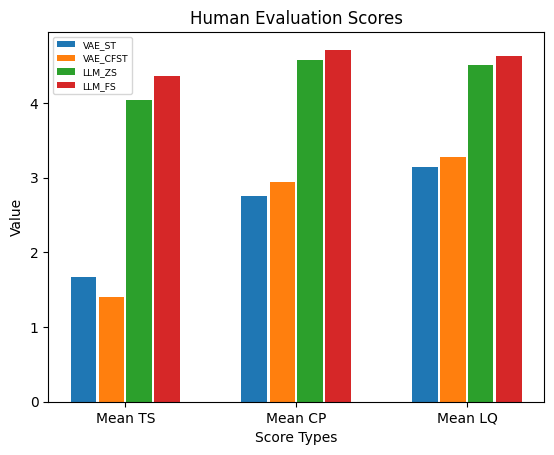

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
  
X = ['Mean TS','Mean CP','Mean LQ']
VAE_ST = list(scores['VAE Style Transfer'][:3])
VAE_CFST = list(scores['VAE CF Style Transfer'][:3])
LLM_ZS = list(scores['LLM Zero Shot'][:3])
LLM_FS = list(scores['LLM Few Shot'][:3])

  
X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.245, VAE_ST, 0.15, label = 'VAE_ST')
plt.bar(X_axis - 0.080, VAE_CFST, 0.15, label = 'VAE_CFST')
plt.bar(X_axis + 0.080, LLM_ZS, 0.15, label = 'LLM_ZS')
plt.bar(X_axis + 0.245, LLM_FS, 0.15, label = 'LLM_FS')
  
plt.xticks(X_axis, X)
plt.xlabel("Score Types")
plt.ylabel("Value")
plt.title("Human Evaluation Scores")
plt.legend(loc='upper left', prop={'size': 6.7})
plt.savefig('/content/drive/MyDrive/NLPPROJECT/HumanEvalFinal/scoresplot.png')

##Data Characterstics

In [ ]:
with open("/content/drive/MyDrive/NLPPROJECT/data/embedding.txt", 'r') as emb:
  k = emb.readlines()

with open("/content/drive/MyDrive/NLPPROJECT/word2index.json", 'r') as f:
  k2 = json.load(f)

with open("/content/drive/MyDrive/NLPPROJECT/data/word2index.json", 'r') as data:
  k3 = json.load(data)

with open("/content/drive/MyDrive/NLPPROJECT/data/index2word.json", 'r') as data2:
  k4 = json.load(data2)

with open("/content/drive/MyDrive/NLPPROJECT/index2word.json", 'r') as data3:
  k5 = json.load(data3)


print(len(k))
print(k2['the'])
print(k3['the'])
print(k4['3'])
print(k5['3'])

9187
3
3
the
the
